# HAR CNN training 

In [141]:
# Imports
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
%run utils/utilities.py

## Prepare data

In [143]:
rootDatasetDir = "./datasets/PTIT/normalized"
X_train, labels_train, list_ch_train = read_data(data_path=rootDatasetDir, split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path=rootDatasetDir, split="test") # test
assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [144]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [145]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [146]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [147]:
# Imports
import tensorflow as tf

### Hyperparameters

In [148]:
batch_size = 600       # Batch size
seq_len = WINDOWN_SIZE          # Number of steps or window size
learning_rate = 0.0001
epochs = 1000

n_classes = NUM_CLASS
n_channels = 9

### Construct the graph
Placeholders

In [149]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

In [151]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [152]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [153]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [154]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

('Epoch: 0/1000', 'Iteration: 5', 'Train loss: 2.939240', 'Train acc: 0.078333')
('Epoch: 1/1000', 'Iteration: 10', 'Train loss: 2.866688', 'Train acc: 0.061667')
('Epoch: 1/1000', 'Iteration: 10', 'Validation loss: 2.830694', 'Validation acc: 0.063333')
('Epoch: 2/1000', 'Iteration: 15', 'Train loss: 2.866122', 'Train acc: 0.068333')
('Epoch: 3/1000', 'Iteration: 20', 'Train loss: 2.834503', 'Train acc: 0.073333')
('Epoch: 3/1000', 'Iteration: 20', 'Validation loss: 2.772100', 'Validation acc: 0.081667')
('Epoch: 4/1000', 'Iteration: 25', 'Train loss: 2.818549', 'Train acc: 0.080000')
('Epoch: 5/1000', 'Iteration: 30', 'Train loss: 2.786442', 'Train acc: 0.081667')
('Epoch: 5/1000', 'Iteration: 30', 'Validation loss: 2.733568', 'Validation acc: 0.086667')
('Epoch: 6/1000', 'Iteration: 35', 'Train loss: 2.772918', 'Train acc: 0.101667')
('Epoch: 7/1000', 'Iteration: 40', 'Train loss: 2.767879', 'Train acc: 0.086667')
('Epoch: 7/1000', 'Iteration: 40', 'Validation loss: 2.704924', 'Vali

('Epoch: 64/1000', 'Iteration: 325', 'Train loss: 1.471111', 'Train acc: 0.538333')
('Epoch: 65/1000', 'Iteration: 330', 'Train loss: 1.445923', 'Train acc: 0.551667')
('Epoch: 65/1000', 'Iteration: 330', 'Validation loss: 1.360493', 'Validation acc: 0.603333')
('Epoch: 66/1000', 'Iteration: 335', 'Train loss: 1.418577', 'Train acc: 0.558333')
('Epoch: 67/1000', 'Iteration: 340', 'Train loss: 1.419719', 'Train acc: 0.560000')
('Epoch: 67/1000', 'Iteration: 340', 'Validation loss: 1.326842', 'Validation acc: 0.613333')
('Epoch: 68/1000', 'Iteration: 345', 'Train loss: 1.381610', 'Train acc: 0.571667')
('Epoch: 69/1000', 'Iteration: 350', 'Train loss: 1.410465', 'Train acc: 0.535000')
('Epoch: 69/1000', 'Iteration: 350', 'Validation loss: 1.295779', 'Validation acc: 0.621667')
('Epoch: 70/1000', 'Iteration: 355', 'Train loss: 1.359498', 'Train acc: 0.591667')
('Epoch: 71/1000', 'Iteration: 360', 'Train loss: 1.340889', 'Train acc: 0.571667')
('Epoch: 71/1000', 'Iteration: 360', 'Validati

('Epoch: 127/1000', 'Iteration: 640', 'Train loss: 0.875633', 'Train acc: 0.710000')
('Epoch: 127/1000', 'Iteration: 640', 'Validation loss: 0.818309', 'Validation acc: 0.735000')
('Epoch: 128/1000', 'Iteration: 645', 'Train loss: 0.865445', 'Train acc: 0.700000')
('Epoch: 129/1000', 'Iteration: 650', 'Train loss: 0.848949', 'Train acc: 0.728333')
('Epoch: 129/1000', 'Iteration: 650', 'Validation loss: 0.810031', 'Validation acc: 0.733333')
('Epoch: 130/1000', 'Iteration: 655', 'Train loss: 0.835942', 'Train acc: 0.740000')
('Epoch: 131/1000', 'Iteration: 660', 'Train loss: 0.833305', 'Train acc: 0.751667')
('Epoch: 131/1000', 'Iteration: 660', 'Validation loss: 0.800525', 'Validation acc: 0.738333')
('Epoch: 132/1000', 'Iteration: 665', 'Train loss: 0.804627', 'Train acc: 0.756667')
('Epoch: 133/1000', 'Iteration: 670', 'Train loss: 0.819929', 'Train acc: 0.748333')
('Epoch: 133/1000', 'Iteration: 670', 'Validation loss: 0.790634', 'Validation acc: 0.741667')
('Epoch: 134/1000', 'Iter

('Epoch: 189/1000', 'Iteration: 950', 'Train loss: 0.627389', 'Train acc: 0.786667')
('Epoch: 189/1000', 'Iteration: 950', 'Validation loss: 0.608850', 'Validation acc: 0.810000')
('Epoch: 190/1000', 'Iteration: 955', 'Train loss: 0.597452', 'Train acc: 0.811667')
('Epoch: 191/1000', 'Iteration: 960', 'Train loss: 0.584938', 'Train acc: 0.820000')
('Epoch: 191/1000', 'Iteration: 960', 'Validation loss: 0.605437', 'Validation acc: 0.810000')
('Epoch: 192/1000', 'Iteration: 965', 'Train loss: 0.584617', 'Train acc: 0.828333')
('Epoch: 193/1000', 'Iteration: 970', 'Train loss: 0.580491', 'Train acc: 0.833333')
('Epoch: 193/1000', 'Iteration: 970', 'Validation loss: 0.601183', 'Validation acc: 0.805000')
('Epoch: 194/1000', 'Iteration: 975', 'Train loss: 0.598268', 'Train acc: 0.808333')
('Epoch: 195/1000', 'Iteration: 980', 'Train loss: 0.565695', 'Train acc: 0.836667')
('Epoch: 195/1000', 'Iteration: 980', 'Validation loss: 0.598080', 'Validation acc: 0.815000')
('Epoch: 196/1000', 'Iter

('Epoch: 250/1000', 'Iteration: 1255', 'Train loss: 0.412935', 'Train acc: 0.880000')
('Epoch: 251/1000', 'Iteration: 1260', 'Train loss: 0.464178', 'Train acc: 0.866667')
('Epoch: 251/1000', 'Iteration: 1260', 'Validation loss: 0.498271', 'Validation acc: 0.850000')
('Epoch: 252/1000', 'Iteration: 1265', 'Train loss: 0.452405', 'Train acc: 0.873333')
('Epoch: 253/1000', 'Iteration: 1270', 'Train loss: 0.448668', 'Train acc: 0.865000')
('Epoch: 253/1000', 'Iteration: 1270', 'Validation loss: 0.495779', 'Validation acc: 0.848333')
('Epoch: 254/1000', 'Iteration: 1275', 'Train loss: 0.474132', 'Train acc: 0.855000')
('Epoch: 255/1000', 'Iteration: 1280', 'Train loss: 0.435112', 'Train acc: 0.861667')
('Epoch: 255/1000', 'Iteration: 1280', 'Validation loss: 0.494476', 'Validation acc: 0.851667')
('Epoch: 256/1000', 'Iteration: 1285', 'Train loss: 0.457565', 'Train acc: 0.873333')
('Epoch: 257/1000', 'Iteration: 1290', 'Train loss: 0.442590', 'Train acc: 0.856667')
('Epoch: 257/1000', 'Ite

('Epoch: 312/1000', 'Iteration: 1565', 'Train loss: 0.343697', 'Train acc: 0.895000')
('Epoch: 313/1000', 'Iteration: 1570', 'Train loss: 0.365514', 'Train acc: 0.886667')
('Epoch: 313/1000', 'Iteration: 1570', 'Validation loss: 0.436752', 'Validation acc: 0.861667')
('Epoch: 314/1000', 'Iteration: 1575', 'Train loss: 0.356138', 'Train acc: 0.886667')
('Epoch: 315/1000', 'Iteration: 1580', 'Train loss: 0.357361', 'Train acc: 0.900000')
('Epoch: 315/1000', 'Iteration: 1580', 'Validation loss: 0.435900', 'Validation acc: 0.860000')
('Epoch: 316/1000', 'Iteration: 1585', 'Train loss: 0.336424', 'Train acc: 0.901667')
('Epoch: 317/1000', 'Iteration: 1590', 'Train loss: 0.336016', 'Train acc: 0.895000')
('Epoch: 317/1000', 'Iteration: 1590', 'Validation loss: 0.434619', 'Validation acc: 0.863333')
('Epoch: 318/1000', 'Iteration: 1595', 'Train loss: 0.345319', 'Train acc: 0.888333')
('Epoch: 319/1000', 'Iteration: 1600', 'Train loss: 0.323248', 'Train acc: 0.903333')
('Epoch: 319/1000', 'Ite

('Epoch: 374/1000', 'Iteration: 1875', 'Train loss: 0.305490', 'Train acc: 0.908333')
('Epoch: 375/1000', 'Iteration: 1880', 'Train loss: 0.280871', 'Train acc: 0.916667')
('Epoch: 375/1000', 'Iteration: 1880', 'Validation loss: 0.400947', 'Validation acc: 0.871667')
('Epoch: 376/1000', 'Iteration: 1885', 'Train loss: 0.278290', 'Train acc: 0.916667')
('Epoch: 377/1000', 'Iteration: 1890', 'Train loss: 0.280360', 'Train acc: 0.915000')
('Epoch: 377/1000', 'Iteration: 1890', 'Validation loss: 0.398515', 'Validation acc: 0.875000')
('Epoch: 378/1000', 'Iteration: 1895', 'Train loss: 0.287373', 'Train acc: 0.910000')
('Epoch: 379/1000', 'Iteration: 1900', 'Train loss: 0.266666', 'Train acc: 0.921667')
('Epoch: 379/1000', 'Iteration: 1900', 'Validation loss: 0.395447', 'Validation acc: 0.868333')
('Epoch: 380/1000', 'Iteration: 1905', 'Train loss: 0.267585', 'Train acc: 0.913333')
('Epoch: 381/1000', 'Iteration: 1910', 'Train loss: 0.284886', 'Train acc: 0.916667')
('Epoch: 381/1000', 'Ite

('Epoch: 436/1000', 'Iteration: 2185', 'Train loss: 0.249138', 'Train acc: 0.925000')
('Epoch: 437/1000', 'Iteration: 2190', 'Train loss: 0.232834', 'Train acc: 0.928333')
('Epoch: 437/1000', 'Iteration: 2190', 'Validation loss: 0.374412', 'Validation acc: 0.883333')
('Epoch: 438/1000', 'Iteration: 2195', 'Train loss: 0.207210', 'Train acc: 0.940000')
('Epoch: 439/1000', 'Iteration: 2200', 'Train loss: 0.219202', 'Train acc: 0.933333')
('Epoch: 439/1000', 'Iteration: 2200', 'Validation loss: 0.377858', 'Validation acc: 0.876667')
('Epoch: 440/1000', 'Iteration: 2205', 'Train loss: 0.202286', 'Train acc: 0.933333')
('Epoch: 441/1000', 'Iteration: 2210', 'Train loss: 0.221522', 'Train acc: 0.943333')
('Epoch: 441/1000', 'Iteration: 2210', 'Validation loss: 0.376738', 'Validation acc: 0.880000')
('Epoch: 442/1000', 'Iteration: 2215', 'Train loss: 0.231765', 'Train acc: 0.930000')
('Epoch: 443/1000', 'Iteration: 2220', 'Train loss: 0.204687', 'Train acc: 0.936667')
('Epoch: 443/1000', 'Ite

('Epoch: 498/1000', 'Iteration: 2495', 'Train loss: 0.202298', 'Train acc: 0.935000')
('Epoch: 499/1000', 'Iteration: 2500', 'Train loss: 0.190087', 'Train acc: 0.946667')
('Epoch: 499/1000', 'Iteration: 2500', 'Validation loss: 0.363491', 'Validation acc: 0.891667')
('Epoch: 500/1000', 'Iteration: 2505', 'Train loss: 0.178112', 'Train acc: 0.946667')
('Epoch: 501/1000', 'Iteration: 2510', 'Train loss: 0.190669', 'Train acc: 0.943333')
('Epoch: 501/1000', 'Iteration: 2510', 'Validation loss: 0.366231', 'Validation acc: 0.886667')
('Epoch: 502/1000', 'Iteration: 2515', 'Train loss: 0.183051', 'Train acc: 0.945000')
('Epoch: 503/1000', 'Iteration: 2520', 'Train loss: 0.179008', 'Train acc: 0.948333')
('Epoch: 503/1000', 'Iteration: 2520', 'Validation loss: 0.362276', 'Validation acc: 0.890000')
('Epoch: 504/1000', 'Iteration: 2525', 'Train loss: 0.184193', 'Train acc: 0.945000')
('Epoch: 505/1000', 'Iteration: 2530', 'Train loss: 0.163434', 'Train acc: 0.950000')
('Epoch: 505/1000', 'Ite

('Epoch: 560/1000', 'Iteration: 2805', 'Train loss: 0.144748', 'Train acc: 0.951667')
('Epoch: 561/1000', 'Iteration: 2810', 'Train loss: 0.141783', 'Train acc: 0.965000')
('Epoch: 561/1000', 'Iteration: 2810', 'Validation loss: 0.353558', 'Validation acc: 0.895000')
('Epoch: 562/1000', 'Iteration: 2815', 'Train loss: 0.162721', 'Train acc: 0.960000')
('Epoch: 563/1000', 'Iteration: 2820', 'Train loss: 0.154262', 'Train acc: 0.958333')
('Epoch: 563/1000', 'Iteration: 2820', 'Validation loss: 0.356468', 'Validation acc: 0.891667')
('Epoch: 564/1000', 'Iteration: 2825', 'Train loss: 0.149164', 'Train acc: 0.955000')
('Epoch: 565/1000', 'Iteration: 2830', 'Train loss: 0.156531', 'Train acc: 0.958333')
('Epoch: 565/1000', 'Iteration: 2830', 'Validation loss: 0.352965', 'Validation acc: 0.891667')
('Epoch: 566/1000', 'Iteration: 2835', 'Train loss: 0.142565', 'Train acc: 0.960000')
('Epoch: 567/1000', 'Iteration: 2840', 'Train loss: 0.146132', 'Train acc: 0.951667')
('Epoch: 567/1000', 'Ite

('Epoch: 622/1000', 'Iteration: 3115', 'Train loss: 0.135558', 'Train acc: 0.960000')
('Epoch: 623/1000', 'Iteration: 3120', 'Train loss: 0.113927', 'Train acc: 0.975000')
('Epoch: 623/1000', 'Iteration: 3120', 'Validation loss: 0.343421', 'Validation acc: 0.900000')
('Epoch: 624/1000', 'Iteration: 3125', 'Train loss: 0.125277', 'Train acc: 0.961667')
('Epoch: 625/1000', 'Iteration: 3130', 'Train loss: 0.129007', 'Train acc: 0.958333')
('Epoch: 625/1000', 'Iteration: 3130', 'Validation loss: 0.344992', 'Validation acc: 0.898333')
('Epoch: 626/1000', 'Iteration: 3135', 'Train loss: 0.134688', 'Train acc: 0.961667')
('Epoch: 627/1000', 'Iteration: 3140', 'Train loss: 0.127336', 'Train acc: 0.961667')
('Epoch: 627/1000', 'Iteration: 3140', 'Validation loss: 0.349586', 'Validation acc: 0.896667')
('Epoch: 628/1000', 'Iteration: 3145', 'Train loss: 0.119023', 'Train acc: 0.976667')
('Epoch: 629/1000', 'Iteration: 3150', 'Train loss: 0.139676', 'Train acc: 0.960000')
('Epoch: 629/1000', 'Ite

('Epoch: 684/1000', 'Iteration: 3425', 'Train loss: 0.114625', 'Train acc: 0.968333')
('Epoch: 685/1000', 'Iteration: 3430', 'Train loss: 0.097374', 'Train acc: 0.970000')
('Epoch: 685/1000', 'Iteration: 3430', 'Validation loss: 0.352612', 'Validation acc: 0.905000')
('Epoch: 686/1000', 'Iteration: 3435', 'Train loss: 0.107158', 'Train acc: 0.968333')
('Epoch: 687/1000', 'Iteration: 3440', 'Train loss: 0.114151', 'Train acc: 0.965000')
('Epoch: 687/1000', 'Iteration: 3440', 'Validation loss: 0.344770', 'Validation acc: 0.903333')
('Epoch: 688/1000', 'Iteration: 3445', 'Train loss: 0.113423', 'Train acc: 0.968333')
('Epoch: 689/1000', 'Iteration: 3450', 'Train loss: 0.100397', 'Train acc: 0.978333')
('Epoch: 689/1000', 'Iteration: 3450', 'Validation loss: 0.348184', 'Validation acc: 0.905000')
('Epoch: 690/1000', 'Iteration: 3455', 'Train loss: 0.108185', 'Train acc: 0.965000')
('Epoch: 691/1000', 'Iteration: 3460', 'Train loss: 0.111085', 'Train acc: 0.966667')
('Epoch: 691/1000', 'Ite

('Epoch: 746/1000', 'Iteration: 3735', 'Train loss: 0.096536', 'Train acc: 0.978333')
('Epoch: 747/1000', 'Iteration: 3740', 'Train loss: 0.113182', 'Train acc: 0.960000')
('Epoch: 747/1000', 'Iteration: 3740', 'Validation loss: 0.349610', 'Validation acc: 0.906667')
('Epoch: 748/1000', 'Iteration: 3745', 'Train loss: 0.109766', 'Train acc: 0.966667')
('Epoch: 749/1000', 'Iteration: 3750', 'Train loss: 0.102573', 'Train acc: 0.976667')
('Epoch: 749/1000', 'Iteration: 3750', 'Validation loss: 0.342721', 'Validation acc: 0.906667')
('Epoch: 750/1000', 'Iteration: 3755', 'Train loss: 0.078936', 'Train acc: 0.980000')
('Epoch: 751/1000', 'Iteration: 3760', 'Train loss: 0.081149', 'Train acc: 0.976667')
('Epoch: 751/1000', 'Iteration: 3760', 'Validation loss: 0.343664', 'Validation acc: 0.903333')
('Epoch: 752/1000', 'Iteration: 3765', 'Train loss: 0.089902', 'Train acc: 0.968333')
('Epoch: 753/1000', 'Iteration: 3770', 'Train loss: 0.090391', 'Train acc: 0.983333')
('Epoch: 753/1000', 'Ite

('Epoch: 808/1000', 'Iteration: 4045', 'Train loss: 0.075807', 'Train acc: 0.983333')
('Epoch: 809/1000', 'Iteration: 4050', 'Train loss: 0.092077', 'Train acc: 0.971667')
('Epoch: 809/1000', 'Iteration: 4050', 'Validation loss: 0.349771', 'Validation acc: 0.913333')
('Epoch: 810/1000', 'Iteration: 4055', 'Train loss: 0.088390', 'Train acc: 0.973333')
('Epoch: 811/1000', 'Iteration: 4060', 'Train loss: 0.083243', 'Train acc: 0.980000')
('Epoch: 811/1000', 'Iteration: 4060', 'Validation loss: 0.344271', 'Validation acc: 0.903333')
('Epoch: 812/1000', 'Iteration: 4065', 'Train loss: 0.067790', 'Train acc: 0.986667')
('Epoch: 813/1000', 'Iteration: 4070', 'Train loss: 0.064086', 'Train acc: 0.990000')
('Epoch: 813/1000', 'Iteration: 4070', 'Validation loss: 0.350439', 'Validation acc: 0.910000')
('Epoch: 814/1000', 'Iteration: 4075', 'Train loss: 0.072610', 'Train acc: 0.980000')
('Epoch: 815/1000', 'Iteration: 4080', 'Train loss: 0.071468', 'Train acc: 0.983333')
('Epoch: 815/1000', 'Ite

('Epoch: 870/1000', 'Iteration: 4355', 'Train loss: 0.059405', 'Train acc: 0.990000')
('Epoch: 871/1000', 'Iteration: 4360', 'Train loss: 0.079401', 'Train acc: 0.975000')
('Epoch: 871/1000', 'Iteration: 4360', 'Validation loss: 0.345337', 'Validation acc: 0.908333')
('Epoch: 872/1000', 'Iteration: 4365', 'Train loss: 0.079039', 'Train acc: 0.975000')
('Epoch: 873/1000', 'Iteration: 4370', 'Train loss: 0.097591', 'Train acc: 0.968333')
('Epoch: 873/1000', 'Iteration: 4370', 'Validation loss: 0.345967', 'Validation acc: 0.908333')
('Epoch: 874/1000', 'Iteration: 4375', 'Train loss: 0.073564', 'Train acc: 0.976667')
('Epoch: 875/1000', 'Iteration: 4380', 'Train loss: 0.059402', 'Train acc: 0.988333')
('Epoch: 875/1000', 'Iteration: 4380', 'Validation loss: 0.347774', 'Validation acc: 0.910000')
('Epoch: 876/1000', 'Iteration: 4385', 'Train loss: 0.064955', 'Train acc: 0.980000')
('Epoch: 877/1000', 'Iteration: 4390', 'Train loss: 0.071847', 'Train acc: 0.985000')
('Epoch: 877/1000', 'Ite

('Epoch: 932/1000', 'Iteration: 4665', 'Train loss: 0.065222', 'Train acc: 0.981667')
('Epoch: 933/1000', 'Iteration: 4670', 'Train loss: 0.080846', 'Train acc: 0.973333')
('Epoch: 933/1000', 'Iteration: 4670', 'Validation loss: 0.346153', 'Validation acc: 0.906667')
('Epoch: 934/1000', 'Iteration: 4675', 'Train loss: 0.050518', 'Train acc: 0.988333')
('Epoch: 935/1000', 'Iteration: 4680', 'Train loss: 0.053867', 'Train acc: 0.988333')
('Epoch: 935/1000', 'Iteration: 4680', 'Validation loss: 0.342653', 'Validation acc: 0.908333')
('Epoch: 936/1000', 'Iteration: 4685', 'Train loss: 0.069060', 'Train acc: 0.980000')
('Epoch: 937/1000', 'Iteration: 4690', 'Train loss: 0.065025', 'Train acc: 0.978333')
('Epoch: 937/1000', 'Iteration: 4690', 'Validation loss: 0.343101', 'Validation acc: 0.905000')
('Epoch: 938/1000', 'Iteration: 4695', 'Train loss: 0.067715', 'Train acc: 0.976667')
('Epoch: 939/1000', 'Iteration: 4700', 'Train loss: 0.070132', 'Train acc: 0.983333')
('Epoch: 939/1000', 'Ite

('Epoch: 994/1000', 'Iteration: 4975', 'Train loss: 0.040512', 'Train acc: 0.991667')
('Epoch: 995/1000', 'Iteration: 4980', 'Train loss: 0.055916', 'Train acc: 0.985000')
('Epoch: 995/1000', 'Iteration: 4980', 'Validation loss: 0.346429', 'Validation acc: 0.910000')
('Epoch: 996/1000', 'Iteration: 4985', 'Train loss: 0.050262', 'Train acc: 0.983333')
('Epoch: 997/1000', 'Iteration: 4990', 'Train loss: 0.049488', 'Train acc: 0.988333')
('Epoch: 997/1000', 'Iteration: 4990', 'Validation loss: 0.353780', 'Validation acc: 0.905000')
('Epoch: 998/1000', 'Iteration: 4995', 'Train loss: 0.047762', 'Train acc: 0.991667')
('Epoch: 999/1000', 'Iteration: 5000', 'Train loss: 0.041315', 'Train acc: 0.993333')
('Epoch: 999/1000', 'Iteration: 5000', 'Validation loss: 0.349057', 'Validation acc: 0.908333')


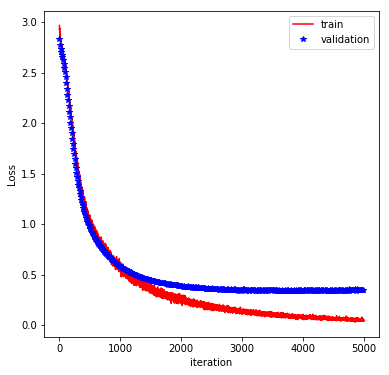

In [155]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

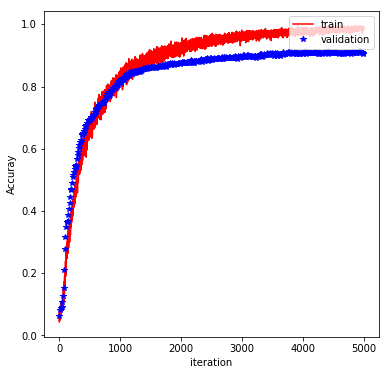

In [156]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [157]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.814167
